In [33]:
from datagen import *

In [69]:
df_graph = pickle.load(open('../data/random_graph/ucla_20walk_graph.pkl', 'rb'))
df_dynamics = pd.read_csv("../data/dynamics_pairs/fca_k8_ucla_20walk_dynamics.csv")
y = df_dynamics.y
base = df_dynamics.baseline_width
df_dynamics = df_dynamics.loc[:, 's1_1':'s50_20']
df = pd.read_csv("../data/dynamics_pairs/fca_k8_ucla_20walk_colored_adj.csv")

In [71]:
# merge true adj and colored adj side by side
scale = 4 # scale down colored adj
X = pd.concat([pd.DataFrame(df_graph.T), df/scale], axis=1)

In [72]:
Y_data = y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X.values, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 8
SDL_BCD_class_new = SDL_BCD(X=[X_train.T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

results_dict_new = SDL_BCD_class_new.fit(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

  0%|          | 0/100 [00:00<?, ?it/s]

initial loading beta [[-0.73512138 -0.6286509   0.55454522  0.26521447  0.91369416  0.48397605
   0.62153749 -0.89793468  0.12886815]]


100%|██████████| 100/100 [16:59<00:00, 10.20s/it]  


!!! pred_type filter


In [73]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_dynamics = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_dynamics)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[[447  43]
 [131 358]]
Precision: 0.893
Recall: 0.732
F1: 0.804
Accuracy: 0.822


In [74]:
Y_data = y
under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(pd.concat([df_dynamics, base], axis=1, join='inner').copy(), Y_data)
Y_baseline = X_res.baseline_width
Y_data = y_res

#baseline model
length = len(Y_baseline[Y_baseline==False])
Y_baseline[random.sample(list(Y_baseline[Y_baseline==False].index),length//2)] = True
conf_matrix_baseline = confusion_matrix(y_true=Y_data, y_pred=Y_baseline)
print(conf_matrix_baseline)
print('Precision: %.3f' % precision_score(Y_data, Y_baseline))
print('Recall: %.3f' % recall_score(Y_data, Y_baseline))
print('F1: %.3f' % f1_score(Y_data, Y_baseline))
print('Accuracy: %.3f' % accuracy_score(Y_data, Y_baseline))

[[1234 1213]
 [ 636 1811]]
Precision: 0.599
Recall: 0.740
F1: 0.662
Accuracy: 0.622


In [75]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 8,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          5.74572696e-10, 0.00000000e+00, 0.00000000e+00],
         [6.28242065e-03, 1.28574396e-03, 4.72128000e-03, ...,
          7.85638600e-03, 3.52593540e-03, 5.30176572e-03],
         [1.06504440e-03, 0.00000000e+00, 3.85507691e-04, ...,
          1.52092210e-03, 1.90223118e-04, 2.52265718e-04],
         ...,
         [0.00000000e+00, 0.00000000e+00, 1.67124637e-03, ...,
          1.66214080e-03, 2.14000610e-04, 0.00000000e+00],
         [0.00000000e+00, 3.84336139e-05, 9.39988338e-04, ...,
          9.42025101e-04, 1.49764501e-04, 2.03851603e-04],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.00937439e-10]]),
  array([[ 2.00945304,  0.37192066, -0.10160605,  0.03060415, -0.50875917,
           0.01291823,  0.0778692 , -0.01441646, -0.1

In [76]:
pickle.dump(results_dict_new, open('temp.pkl', 'wb'))

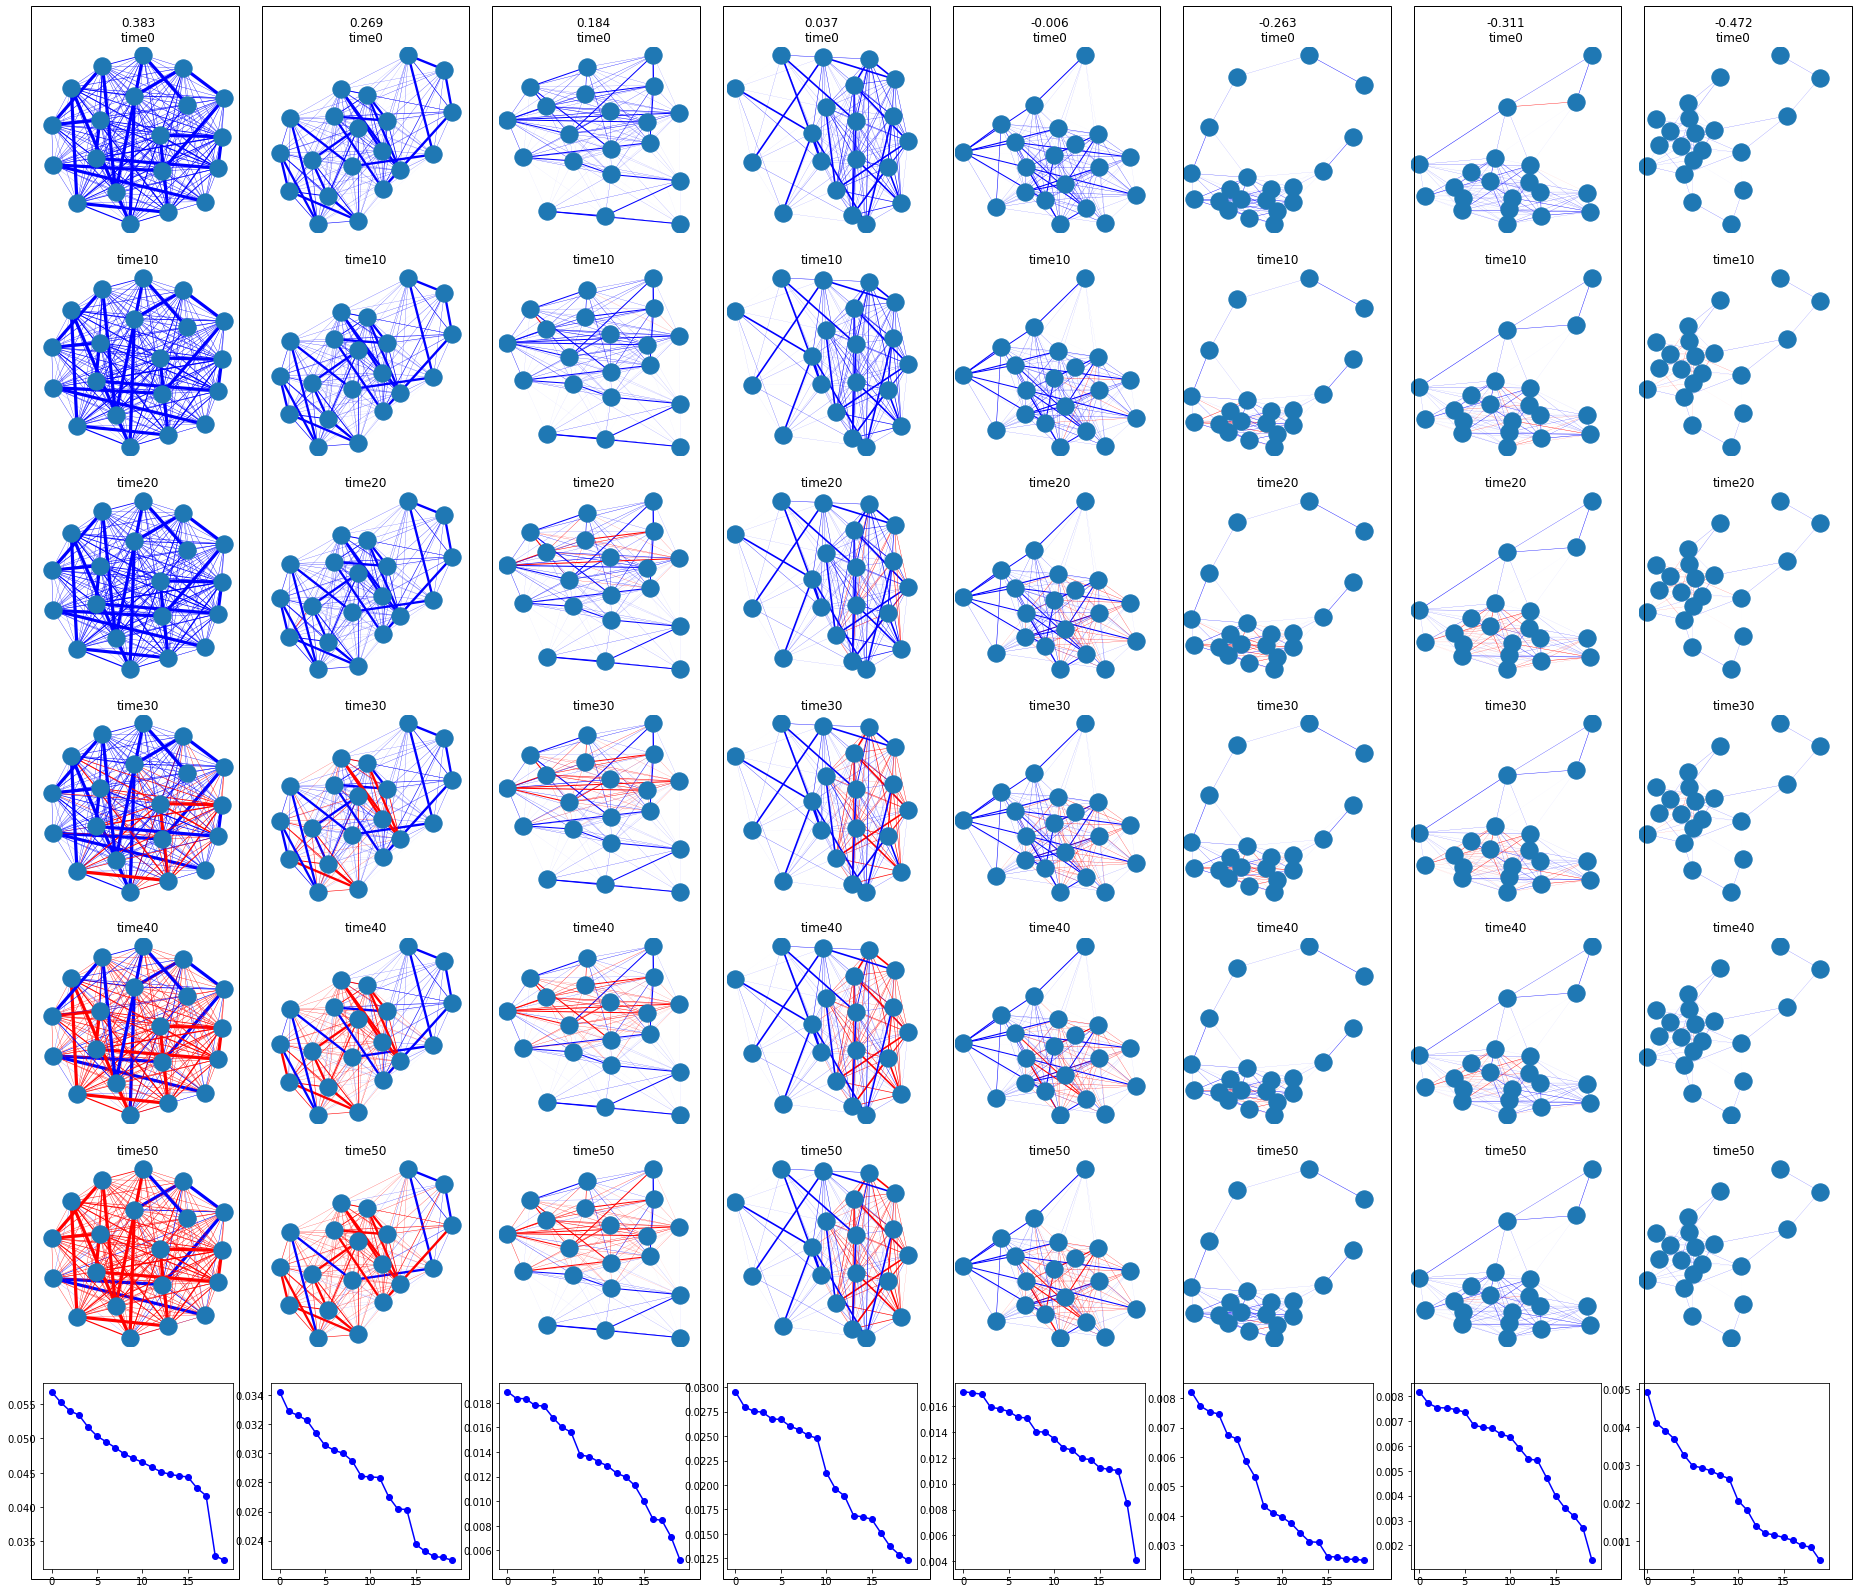

In [80]:
ncol = r
nrow = 6+1
num_nodes = 20
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
sorted_indices = np.argsort(results_dict_new["loading"][1][0][1:])[::-1]
for i in range(ncol):
    ind = sorted_indices[i]
    
    #learned adjacency matrix
    df_adj = pd.DataFrame(results_dict_new["loading"][0].T[ind][0:400].reshape(-1, 20))
    G = nx.from_pandas_adjacency(df_adj)
    edges = G.edges()
    weights = [300*G[u][v]['weight'] for u,v in edges] #weight of learned adjacency matrix
    
    deg_seq = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
    axs[6, i].plot(deg_seq, "b-", marker="o")
        
    
    for j in range(nrow-1):
        col_adj = results_dict_new["loading"][0].T[ind][0+j*10*400:400+j*10*400].reshape(-1, 20)
        
        G1 = nx.Graph()
        for a in range(num_nodes):
            for b in range(num_nodes):
                u = list(G.nodes())[a]
                v = list(G.nodes())[b]
                if G.has_edge(u,v) and u!=v:
                    if col_adj[u, v] == 0: #all synchronizing edges
                        G1.add_edge(u,v, color='r')
                    else:
                        G1.add_edge(u,v, color='b')
        
        edges = G1.edges()
        colors = [G1[u][v]['color'] for u,v in edges]
        nx.draw(G1, edge_color=colors,width=weights, ax=axs[j, i], pos = nx.spring_layout(G1, seed=123))
        
        
        
        #sns.heatmap(results_dict_new["loading"][0].T[ind][0+j*10*400:400+j*10*400].reshape(-1, 20),
                    #ax = axs[j, i])
        if j == 0:
            axs[j, i].title.set_text(str(round(results_dict_new["loading"][1][0][1:][sorted_indices[i]], 3))
                                 +"\ntime"+str(j*10))
        else:
            axs[j, i].title.set_text("time"+str(j*10))

        
    rect = plt.Rectangle((0.12+i*0.1, 0.12), 0.09, 0.78, fill=False, color="k", lw=1, 
                         zorder=1000, transform=fig.transFigure, figure=fig)
    fig.patches.extend([rect])

In [81]:
fig.savefig("temp.jpg")

In [79]:
results_dict_new = pickle.load(open('../data/dynamics_pairs/fca_k8_nws_20walk_colored_adj_sdl_dict.pkl', 'rb'))
